In [9]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [10]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [11]:
# r before string will prevent Python from interpreting escape characters.
DIRECTORY = r"C:\Users\ragus\Deep_learning_face mask deduction\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [12]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

[INFO] loading images...


In [13]:
from imutils import paths

# Define the path to your dataset
dataset_path = r"C:\Users\ragus\Deep_learning_face mask deduction\dataset"

# List all image paths in the dataset
imagePaths = list(paths.list_images(dataset_path))

# Print the number of images found and a few example paths
print(f"Found {len(imagePaths)} images.")
print("Example image paths:")
print(imagePaths[:5])  # Print first 5 image paths


Found 3845 images.
Example image paths:
['C:\\Users\\ragus\\Deep_learning_face mask deduction\\dataset\\without_mask\\0_0_aidai_0014.jpg', 'C:\\Users\\ragus\\Deep_learning_face mask deduction\\dataset\\without_mask\\0_0_aidai_0029.jpg', 'C:\\Users\\ragus\\Deep_learning_face mask deduction\\dataset\\without_mask\\0_0_aidai_0043.jpg', 'C:\\Users\\ragus\\Deep_learning_face mask deduction\\dataset\\without_mask\\0_0_aidai_0074.jpg', 'C:\\Users\\ragus\\Deep_learning_face mask deduction\\dataset\\without_mask\\0_0_aidai_0084.jpg']


In [14]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


C:\Users\ragus\anaconda3\Lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [15]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [16]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [17]:
# Construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [18]:
# Construct the validation image generator
val_aug = ImageDataGenerator()

In [19]:
# Create data generators
train_generator = aug.flow(trainX, trainY, batch_size=BS)
val_generator = val_aug.flow(testX, testY, batch_size=BS)

In [20]:
train_generator 

In [21]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

C:\Users\ragus\AppData\Local\Temp\ipykernel_13964\4269477345.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


In [22]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [23]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [24]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [25]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [26]:
# Compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [27]:
# Train the head of the network
print("[INFO] training head...")
H = model.fit(
    train_generator,
    steps_per_epoch=len(trainX) // BS,
    validation_data=val_generator,
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/10


C:\Users\ragus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 734ms/step - accuracy: 0.7201 - loss: 0.5840 - val_accuracy: 0.9766 - val_loss: 0.1655
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.2205 - val_accuracy: 1.0000 - val_loss: 0.6639
Epoch 3/10


C:\Users\ragus\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


96/96 ━━━━━━━━━━━━━━━━━━━━ 64s 653ms/step - accuracy: 0.9595 - loss: 0.1777 - val_accuracy: 0.9792 - val_loss: 0.0909
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - accuracy: 0.9688 - loss: 0.0856 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 647ms/step - accuracy: 0.9749 - loss: 0.1064 - val_accuracy: 0.9870 - val_loss: 0.0631
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.9375 - loss: 0.1125 - val_accuracy: 1.0000 - val_loss: 0.4335
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 63s 646ms/step - accuracy: 0.9720 - loss: 0.0895 - val_accuracy: 0.9857 - val_loss: 0.0547
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step - accuracy: 0.9375 - loss: 0.1547 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 65s 658ms/step - accuracy: 0.9788 - loss: 0.0691 - val_accuracy: 0.9870 - val_loss: 0.0473
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step - accuracy: 0.9688 - loss: 0.1035 - val_accuracy: 1.0000 -

In [28]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 472ms/step


In [29]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


In [30]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       383
without_mask       0.99      0.98      0.99       386

    accuracy                           0.99       769
   macro avg       0.99      0.99      0.99       769
weighted avg       0.99      0.99      0.99       769



In [31]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("Face_Mask_Detector.h5")

[INFO] saving mask detector model...


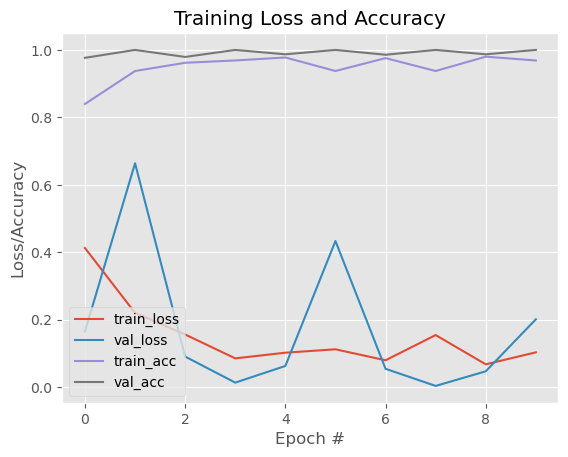

In [32]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")